<a href="https://colab.research.google.com/github/fbromberg/LOVMe/blob/master/paper_b.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

##Sección Experimental

La siguiente celda nos permitirá utilizar R en algunas celdas. Además cargamos los archivos con los datos de las etiquetas.

In [ ]:
# activate R magic
%load_ext rpy2.ipython

!gdown https://drive.google.com/uc?id=13gd9Wo8QtDj6vViCRFVoMZ3ox0f93n4i
!unzip etiquetas.zip

/usr/local/lib/python3.6/dist-packages/rpy2/robjects/pandas2ri.py:14: FutureWarning: pandas.core.index is deprecated and will be removed in a future version.  The public classes are available in the top-level namespace.
  from pandas.core.index import Index as PandasIndex
/usr/local/lib/python3.6/dist-packages/rpy2/robjects/pandas2ri.py:34: UserWarning: pandas >= 1.0 is not supported.
  warnings.warn('pandas >= 1.0 is not supported.')


Downloading...
From: https://drive.google.com/uc?id=13gd9Wo8QtDj6vViCRFVoMZ3ox0f93n4i
To: /content/etiquetas.zip
100% 70.7k/70.7k [00:00<00:00, 27.3MB/s]
Archive:  etiquetas.zip
   creating: ResultadosEtiquetados/
   creating: ResultadosEtiquetados/0/
  inflating: ResultadosEtiquetados/0/file00000036.chk  
  inflating: ResultadosEtiquetados/0/file00000037.chk  
  inflating: ResultadosEtiquetados/0/file00000038.chk  
  inflating: ResultadosEtiquetados/0/file00000039.chk  
  inflating: ResultadosEtiquetados/0/file0000003A.chk  
  inflating: ResultadosEtiquetados/0/file0000003B.chk  
  inflating: ResultadosEtiquetados/0/file0000003C.chk  
  inflating: ResultadosEtiquetados/0/file0000003D.chk  
  inflating: ResultadosEtiquetados/0/file0000003E.chk  
  inflating: ResultadosEtiquetados/0/file0000003F.chk  
  inflating: ResultadosEtiquetados/0/file00000040.chk  
  inflating: ResultadosEtiquetados/0/file00000041.chk  
  inflating: ResultadosEtiquetados/0/file00000042.chk  
  inflating: Resulta

In [ ]:
%%R
library(tidyverse)
library(magrittr)

R[write to console]: ── Attaching packages ─────────────────────────────────────── tidyverse 1.3.0 ──

R[write to console]: ✔ ggplot2 3.3.0     ✔ purrr   0.3.3
✔ tibble  3.0.0     ✔ dplyr   0.8.5
✔ tidyr   1.0.2     ✔ stringr 1.4.0
✔ readr   1.3.1     ✔ forcats 0.5.0

R[write to console]: ── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()

R[write to console]: 
Attaching package: ‘magrittr’


R[write to console]: The following object is masked from ‘package:purrr’:

    set_names


R[write to console]: The following object is masked from ‘package:tidyr’:

    extract




En esta sección se presenta el workflow utilizado para construir un sistema computacional que nos permitiera validar que la localización de imágenes 2D sobre reconstrucciones 3D de un viñedo, es lo suficientemente precisa como para identificar unívocamente determinados objetos presentes en dichas imágenes.

En concreto, en las siguientes subsecciones explicaremos la infraestructura general de localización utilizada y la creación del modelo 3D de la escena.

#Métodos y Materiales

En esta sección se intentará explicar el enfoque que se adoptó y los sistemas que se desarrollaron para llevar adelante los experimentos que verifiquen la hipótesis propuesta. En concreto, estos experimentos intentan validar empíricamente que la localización de imágenes 2D sobre reconstrucciones 3D de un viñedo, es lo suficientemente precisa como para identificar unívocamente determinados objetos presentes en la imagen 2D. Particularmente, hablamos de objetos que forman parte de la planta de vid, pero que son reconoscibles por sí mismos y pueden ser individualizados como granos de uva, hojas y yemas.

En la literatura se pueden encontrar casos exitosos de modelos de aprendizaje de máquina que pueden detectar y hasta segmentar instancias de partes de la planta en imágenes. Por otro lado, también existen métodos de mapeo y localización simultánea (SLAM) que permiten generar modelos 3D a partir de una serie de imágenes de la misma escena capturadas desde distinta perspectiva. Por lo tanto con las herramientas existentes hasta el momento se podrían generar modelos 3D de escenas de viñedos segmentados por sectores de la planta.

Sin embargo, lo que no se ha intentado hasta ahora es individualizar cada uno de estos objetos que pertenecen a una misma clase y poder distinguirlos entre sí dentro de dicho modelo. Es decir, poder distinguir una hoja o un grano de uva del resto de los de su misma clase. 

Lo que se intentará demostrar en el siguiente desarrollo experimental es que, asumiendo que existe una forma de individualizar estos objetos dentro de un modelo 3D de una escena vitivinícola, es suficiente conocer la posición desde la cual se capturó una imagen de la misma escena para poder identificar unívocamente a cada uno de los objetos que aparezcan en dicha imagen.

El workflow de trabajo propuesto para llevar adelante esta identificación sería el siguiente:

1. Generar un modelo 3D que permita localizar una imagen dentro de la escena solamente a partir de las características visuales presentes en la misma. 
2. Establecer la ubicación de cada objeto identificable dentro del modelo 3D mediante un proceso de triangulación, a partir de la ubicación del objeto en al menos dos imágenes con diferente  perspectiva. 
3. Dada una imagen de la escena y un objeto a identificar en ella:
  
  a. Inferir la ubicación de la cámara dentro del modelo 3D a partir de la perspectiva que se observa en la imagen.

  b. Reproyectar los objetos identificables del modelo que son visibles en la imagen desde la perspectiva inferida.

  c. Detectar la ubicación real del objeto a identificar en la imagen utilizando coordenadas en píxeles 

  d. Comparar la ubicación real del objeto en cada imagen de testeo (paso c) con las reproyecciones obtenidas mediante localización (paso b).

  e. Identificar el objeto en cuestión eligiendo la reproyección cuya intersección con la ubicación real sea mayor.

En las siguientes secciones explicaremos los métodos y materiales utilizados para ejecutar cada uno de los pasos descriptos en el workflow. En la sección 1 se hablará del proceso de creación del modelo 3D y de la infraestructura general utilizada para tal fin (paso 1). En la sección 2 se hablará de los objetos identificables que utilizaremos en los experimentos y su ubicación dentro del modelo 3D (paso 2). Por último, en la sección 3 se define el proceso de ejecución de los experimentos sobre imágenes de la escena para obtener datos acerca de la identificación de los objetos presentes en ella (paso 3).

## Sección 1: Creación del modelo 3D de la escena

La infraestructura general de mapeo y localización está provista por la librería ORB_SLAM2 en su versión monocular. ORB_SLAM2 es un sistema SLAM (Simultaneous Localization And Mapping) basado en features visuales que opera en tiempo real en ambientes grandes y pequeños, interiores o al aire libre. [[Mur Artal et.al, 2015]](http://webdiis.unizar.es/~raulmur/MurMontielTardosTRO15.pdf).



La elección de este sistema por sobre otros similares se basó en la presencia de las siguientes características:

* utilización exclusiva de features visuales para todas las tareas de SLAM (seguimiento, mapeo y cierre de bucles)
* robustez a movimientos bruscos
* cierre de bucles con una línea de base amplia
* relocalización e inicialización automática 

Para la creación de un modelo 3D a través de cualquier sistema SLAM basado en la reconstrucción a partir de dos vistas, se necesita un flujo de imágenes consecutivas con una mínima variación entre ellas. Para conseguirlo se capturaron videos en condiciones reales de campo y utilizando equipamiento fotográfico de bajo costo. 

Esto videos correspondían a una de dos categorías:

* ***Videos de Entrenamiento***: se utilizarían para generar el modelo 3D propiamente dicho (paso 1 y 2 del workflow descripto). Para poder capturar estos videos se instalaron códigos QR del tamaño de una hoja A4 en distintos puntos de la hilera, de manera de ayudar al sistema ORB_SLAM2 a inicializar el mapa de una manera más rápida debido a sus formas fácilmente detectables y su invariabilidad a través del tiempo. Los videos se grababan a un metro de distancia separando los sectores contenidos entre un QR y otro. Por ejemplo, el video del sector 1 comenzaba mirando de frente al QR1 avanzaba mirando hacia la hilera con un ángulo de incidencia de 45°, miraba de frente al QR2 y retrocedía mirando hacia la hilera con un ángulo de incidencia de 90° terminando de frente al QR1. Cabe destacar que el camarógrafo se movía muy lentamente para intentar reducir los movimientos bruscos de la cámara.
* ***Videos de Testeo***: se utilizarían para evaluar la localización sobre el modelo construído (paso 3 del workflow descripto). Se capturaban a un metro de distancia de la hilera, dando un giro completo alrededor de la misma con un ángulo de incidencia de 90° y desplazándose a una velocidad de paso de hombre.

El resultado obtenido a partir de estos videos fue el siguiente ![modelo3D](https://i.imgur.com/ZaDM4C3.png)

## Sección 2: Incorporación al modelo 3D de las instancias identificables 

Una vez concluido el proceso de creación del modelo a partir de las imágenes de entrenamiento, el siguiente paso consiste en detectar instancias de las clases estructurales de interés en al menos dos imágenes donde sean visibles desde diferentes perspectivas.


La forma más fácil de detectar estas instancias en las imágenes es utilizar modelos de aprendizaje de máquinas entrenados específicamente para tal tarea de los cuales ya e habló anteriormente. Sin embargo, la utilización de estos algoritmos introduciría errores que no son propios del esquema de identificación por localización propuesto, sino que son propios de los mismos modelos utilizados para la detección. De esta manera, no se podría determinar que proporción del error total observado correspondería a errores de localización y cual correspondería a errores del detector.

Para eliminar estos errores de detección, se decidió etiquetar manualmente la ubicación de los objetos a identificar en las imágenes. Sin embargo, este proceso podría tornarse tedioso e impreciso si se tuviera que etiquetar las partes de la planta que son irregulares por naturaleza e incluso se obstruyen entre ellas dificultando la tarea de saber donde termina un objeto y comienza el siguiente. Por lo tanto, se decidió utilizar marcadores artificiales en la escena como los objetos que intentaríamos identificar en los experimentos.



Estos marcadores debían ser lo suficientemente llamativos y sencillos, geométricamente hablando, como para facilitar el etiquetado manual de la ubicación de los objetos. Además, debían ser lo suficientemente pequeños como para que no beneficiaran ni entorpecieran el proceso de creación del modelo 3D ni el de localización dentro del modelo, ya que este esquema de identificación propuesto debe funcionar en escenas reales que no contengan estos marcadores. Intentando cumplir con estas restricciones se utilizaron cuadrados rojos de 3 cm de lado fabricados con un plástico rígido para evitar deformaciones. 

Estos marcadores debían ser incorporados al modelo 3D de manera artificial ya que habían sido diseñados para que sus características visuales fueran pasadas por alto por ORBSLAM. Por lo tanto añadimos un módulo al sistema que nos permitiera incorporar puntos a demanda al modelo imitando el proceso de triangulación provisto por ORBSLAM. La única diferencia en el flujo de trabajo era que, en vez de confiar en que un detector de características visuales encontrara los puntos del marcador dentro de la imagen, una interfaz de usuario te permitía seleccionar manualmente las 4 esquinas del marcador en dos imágenes de entrenamiento capturadas desde diferentes perspectivas. ![Proceso de Triangulación](https://i.imgur.com/PNjPKoA.png)

## Sección 3: Proceso de obtención de las métricas de identificación 

Concluido el proceso de incorporar manualmente los marcadores (paso 2 del workflow), el modelo 3D estaba listo para tratar de localizar las imágenes de los videos de testeo (paso 3). Mediante una pequeña modificación al código fuente de ORBSLAM, se pudo lograr registrar todos los frames en los cuales se pudiera observar un marcador y la posición exacta en pixeles que ocupaba dentro de dicho frame. Es decir, mediante el proceso de reproyección, se pudo recuperar la posición de los marcadores estimada por el sistema dentro de imágenes que no fueron utilizadas para generar el modelo en un primer momento (incisos a y b del paso 3 del workflow).

Una vez que ya se contaba con las **predicciones** de la ubicación de los marcadores en cada frame, sólo se tenían que comparar con la ubicación **real** de dichos marcadores en los frames. Para obtener estas ubicaciones reales (inciso c del paso 3 del workflow) se desarrolló otro módulo que, a través de una interfaz de usuario, permitía marcar las cuatro esquinas de los marcadores en cada uno de los frames con al menos una observación registrada. Luego de este proceso se obtenía la distancia euclidiana en el espacio 2D de la imagen entre la predicción y la etiqueta manual para tener una métrica del error de reproyección del sistema (inciso d del paso 3 del workflow).

Al finalizar el proceso descripto anteriormente se contaba con un dataset como el siguiente.

In [ ]:
%%capture
%%R 
rutasDatos = readLines("rutasResultadosEtiquetados2.txt")
nombreColumnas <- c("timestampFrame", "idFrame", "descripción", "idEstructura", "indicePunto", "xRep",
                      "yRep", "distancia3D", "angulo2", "horaEtiquetado", "estado", "xTrue", "yTrue",
                      "distancia" )
etiquetas <- read_tsv(rutasDatos[1], col_names = nombreColumnas, na = "-")
for (ruta in rutasDatos[-1]){
  etiquetasTemp <- read_tsv(ruta, col_names = nombreColumnas, na = "-")
  etiquetas <- bind_rows(etiquetas,etiquetasTemp)
}

In [ ]:
%%R 
knitr::kable(head(etiquetas))



| timestampFrame| idFrame|descripción      | idEstructura| indicePunto|    xRep|    yRep| distancia3D| angulo2|horaEtiquetado           |estado  | xTrue| yTrue| distancia|
|--------------:|-------:|:----------------|------------:|-----------:|-------:|-------:|-----------:|-------:|:------------------------|:-------|-----:|-----:|---------:|
|        30.2500|    1811|Marker_Planta_11 |            5|           0| 460.663| 216.403|     5.05651| 3.03762|Tue Jan 28 12:31:59 2020 |VISIBLE |   466|   241|   25.1693|
|        30.2500|    1811|Marker_Planta_11 |            5|           1| 478.557| 204.020|     5.05651| 3.03762|Tue Jan 28 12:31:59 2020 |VISIBLE |   483|   229|   25.3720|
|        30.2500|    1811|Marker_Planta_11 |            5|           2| 489.570| 221.577|     5.05651| 3.03762|Tue Jan 28 12:31:59 2020 |VISIBLE |   494|   244|   22.8564|
|        30.2500|    1811|Marker_Planta_11 |            5|           3| 474.371| 234.839|     5.05651| 3.03762|Tue Jan 28 12:31:59 2020 |V

Como se puede ver en la salida anterior, se guarda información en cada fila sobre:

* el marker:
    + __idEstructura__: el id del marker dentro del mapa
    + __descripción__: indica en qué planta se lo ubicó en la hilera real
    + __idPunto__: indica el índice de la esquina dentro del marker (en este caso son cuatro esquinas por marker)
* el frame:
    + __idFrame__: indice del frame desde que arrancó el video
    + __timestampFrame__: cantidad de segundos desde que arrancó el video
* el etiquetado:
    + __xRep,yRep__: coordenadas x e y de la reproyección del marker 3D sobre el frame (donde el sistema cree que el marker está)
    + __xTrue, yTrue__: coordenadas x e y de la ubicació real del marker (según el humano que lo etiquetó manualmente)
    + __estado__: clasificación de la calidad del frame hecha por el etiquetador (VISIBLE, OBSTRUIDO O LEJANO)
    + __distancia__: diferencia en píxeles entre los puntos etiquetados y reproyectados
    + __horaEtiquetado__: fecha y hora en que se llevó adelante el etiquetado
* la ubicación de la cámara:
    + distancia3D: distancia entre la cámara inferida y el marker real (usa la escala propia del mapa, se debe pasar a metros)
    + angulo2: ángulo de incidencia de la recta de visión sobre el plano del marker (que se asume paralelo al de la hilera) en radianes

En el siguiente script se hacen algunos ajustes al dataframe para que sea más fácil trabajar con él.

* se cambia el ángulo a grados sexagesimales
* se separa la descripción en 3 columnas y se queda solo con el número de planta
* se eliminan columnas innecesarias para el análisis como la hora de etiquetado
* se agrega una columna idEtiqueta que sea la clave primaria de la etiqueta combinando el idPlanta con el idFrame por las dudas que se repita el idFrame debido a que los frames provienen de distintos videos.

In [ ]:
%%R
#transforma a grados sexagesimales el ángulo de incidencia de la recta de visión y la hilera
etiquetas$angulo2 <- etiquetas$angulo2 * 180 * (1/pi)

#Separa la descripción en 3 columnas y se queda solo con el número de planta. Además elimina columnas innecesarias como la hora de etiquetado.
etiquetas <- etiquetas %>% 
  separate(descripción, into = c("col1", "col2", "idPlanta")) %>%
    select(-c(col1,col2, horaEtiquetado))
etiquetas <- etiquetas %>%
      bind_cols(tibble("idEtiqueta"=paste(etiquetas$idPlanta,etiquetas$idFrame,sep="-")))

etiquetas <- etiquetas[order(etiquetas$idPlanta,etiquetas$idFrame),]
knitr::kable(head(etiquetas))



| timestampFrame| idFrame|idPlanta | idEstructura| indicePunto|    xRep|    yRep| distancia3D|  angulo2|estado  | xTrue| yTrue| distancia|idEtiqueta |
|--------------:|-------:|:--------|------------:|-----------:|-------:|-------:|-----------:|--------:|:-------|-----:|-----:|---------:|:----------|
|        7.88333|     469|1        |            1|           0| 136.072| 369.383|    0.637317| 83.99218|VISIBLE |   142|   369|   5.94036|1-469      |
|        7.88333|     469|1        |            1|           1| 150.983| 371.944|    0.637317| 83.99218|VISIBLE |   154|   370|   3.58907|1-469      |
|        7.88333|     469|1        |            1|           2| 152.567| 384.329|    0.637317| 83.99218|VISIBLE |   157|   381|   5.54380|1-469      |
|        7.88333|     469|1        |            1|           3| 139.383| 381.828|    0.637317| 83.99218|VISIBLE |   144|   382|   4.62020|1-469      |
|        7.90000|     470|1        |            1|           0| 130.741| 371.625|    0.64261

Hasta ahora se cuenta con un dataset que provee para cada observación un error de reproyección, pero hay que encontrar la forma de transformar estos datos en métricas que determinen que tan factible es usar esto para identificar objetos dentro de una escena vitivinícola.

Es decir, hay dos tareas por hacer:

1. Trasformar experimentos que se hicieron sobre marcadores artificiales en experimentos que simulan detectar partes reales de la planta.
2. Obtener métricas de identificación únicamente a partir del error de reproyección.

En las siguientes secciones se explica como se abordó cada problema.

### Obtención de mediciones sobre partes de la planta a partir de mediciones sobre los marcadores artificiales.


Hasta el momento, los errores de reproyección están discriminados para cada una de las cuatro esquinas de nuestros marcadores. Esto se explica por la forma en que estos datos fueron capturados. Sin embargo, tratar los marcadores como círculos permite simplificar todos los datos que tenemos sobre cada marcador en dos variables:

1. Centro: para indicar la posición del marcador.
2. Radio: para indicar el tamaño del marcador.


Se puede calcular el centro de cada marcador recuperando todas las filas que hacen alusión al mismo frame y obteniendo un centro de masa entre las posiciones (las reproyectadas por un lado y las etiquetadas por otro). Esto funciona porque a la hora de etiquetar nos aseguramos de que hubiera un solo marker por frame.

Tratar a los marcadores como círculos va a permitir tener un único error de reproyección asociado a su posición (distancia entre los centros). Hasta ahora los errores calculados están en escala de píxeles, pero como se conoce el tamaño real de los marcadores (3 cm de lado), se puede calcular para cada frame cuantos píxeles representan un cm (columna pixelsCmRatio) y utilizar ese ratio para obtener un error de reproyección en cm. 

In [ ]:
%%R
#establece que los markers miden 3cm
ladoMarkercm <- 3
diagonalMarkercm <- sqrt(2*ladoMarkercm^2)

#obtengo la lista de los frames
etiquetasVisibles <- filter(etiquetas, estado == "VISIBLE" ) %>%  select(-c(estado))
idsEtiqueta <- unique(etiquetasVisibles$idEtiqueta)

#crea el tibble vacio
data <- tibble(idEtiqueta = "0", idFrame=0,  xCentroRep = 0,  yCentroRep = 0, xCentroTrue = 0,  yCentroTrue = 0,  pixelsCmRatio = 0)
#llena una fila por cada frame
for (id in idsEtiqueta){
  #obtiene todas las filas del mismo frame
  d <- etiquetasVisibles %>% 
        filter(idEtiqueta==id) %>%
         select(idEtiqueta,idFrame,idPlanta,xRep,yRep,xTrue,yTrue)
  if(nrow(d)!=4) print(paste("id",id,"repetido",nrow(d)/4,"veces"))
  #calcula la diagonal en pixeles (asume que los puntos están en orden)
  punto1 <- d[1,c("xTrue","yTrue")]
  punto2 <- d[3,c("xTrue","yTrue")]
  diagonalenpx <- dist(rbind(punto1,punto2))
  #calcula el centro real, el predicho y el ratio de px y cm en el frame
  #luego lo agrega a data como una fila nueva
  data %<>% add_row(
    idEtiqueta = id,
    idFrame = mean(d$idFrame),
    xCentroRep = mean(d$xRep),
    yCentroRep = mean(d$yRep),
    xCentroTrue = mean(d$xTrue),
    yCentroTrue = mean(d$yTrue),
    pixelsCmRatio = as.double(diagonalenpx/diagonalMarkercm)
  )
}
resumenEtiquetas <- data
resumenEtiquetas %<>% filter(idFrame != 0 ) %>% drop_na()
knitr::kable(head(resumenEtiquetas))

[1] "id 3-941 repetido 2 veces"
[1] "id 3-958 repetido 2 veces"
[1] "id 3-962 repetido 2 veces"
[1] "id 3-966 repetido 2 veces"
[1] "id 3-967 repetido 2 veces"
[1] "id 3-975 repetido 2 veces"
[1] "id 3-980 repetido 2 veces"
[1] "id 3-998 repetido 2 veces"
[1] "id 3-1011 repetido 2 veces"
[1] "id 3-1016 repetido 2 veces"


|idEtiqueta | idFrame| xCentroRep| yCentroRep| xCentroTrue| yCentroTrue| pixelsCmRatio|
|:----------|-------:|----------:|----------:|-----------:|-----------:|-------------:|
|1-469      |     469|   144.7512|   376.8710|      149.25|      375.50|      4.527693|
|1-470      |     470|   139.4863|   379.1472|      141.00|      377.25|      3.681787|
|1-471      |     471|   139.4832|   379.1040|      142.25|      377.75|      4.196559|
|1-472      |     472|   146.3348|   384.1528|      147.25|      377.75|      5.011099|
|1-473      |     473|   146.3220|   384.1703|      149.25|      378.75|      3.836955|
|1-474      |     474|   155.7192|   393.3367|      160.75| 

Con el error de reproyección en centímetros, se puede analizar como afecta ese error para identificar las distintas partes de la planta. Para esto se para metrizó cada categoría estructural a partir de 2 valores:

1. ***radio***: radio (en cm.) que debería tener un círculo ubicado en el centro de masa del objeto para encerrarlo por completo.
2. ***separacion***: distancia promedio (en cm.) entre los centros de masa de dos instancias de una categoría estructural en una escena vitivinícola típica

In [ ]:
%%R
clasesEstructurales <-
  tribble(
    ~nombre, ~radio, ~separacion,
    "granosUva",   1,    2,
    "granosGrandes", 1.4,2.8,
    "hojas",       2,    3,
    "yemas",       3,    15)
knitr::kable(clasesEstructurales)



|nombre        | radio| separacion|
|:-------------|-----:|----------:|
|granosUva     |   1.0|        2.0|
|granosGrandes |   1.4|        2.8|
|hojas         |   2.0|        3.0|
|yemas         |   3.0|       15.0|


De esta manera, al modificar el radio de los circulos que representan a los marcadores, se puede adecuar la mediciones obtenidas a los tamaños de cada clase. Como se mantienen las posiciones de acuerdo a lo observado en los datos, se respeta el error de reproyección del sistema para que el análisis siga siendo válido. En la siguiente sección se verá para qué es necesario establecer también una separación entre las instancias. 

###Transformación de los errores de reproyección en métricas de identificación

Hasta ahora los datos obtenidos consisten en errores de reproyección en cm. A continuación se explicará el esquema que proponemos para inferir métricas de identificación a partir de estos datos (inciso e del workflow propuesto).

Para empezar, se necesita que haya más de un objeto de la misma clase en cada foto de testeo para que el esquema de identificación tenga oportunidad de equivocarse. Es decir, se necesitaría una "nube" de marcadores cercanos incorporados al modelo 3D. Para reducir la sobrecarga del etiquetado manual, solo se han  incorporado al modelo un marcador por planta, de manera que se tendrá que simular la existencia de los otros marcadores cercanos. Se hará esto a través de una grilla de elementos del mismo tamaño reproyectados sobre el plano de la imagen de testeo como se muestra en la siguiente figura. Tanto el tamaño como la separación entre las instancias responde a la parametrización de cada clase explicada en la sección anterior.

![GrillaSimulada](https://i.imgur.com/ffeVXJ7.png)

Para generar esta grilla simulada se usará una función que recibe los siguientes parámetros:

* __objetoTrue__: posición que ocupará el objeto que debería ser identificado dentro de la grilla
* __objetosxFila__: cantidad de objetos en una fila de la grilla
* __nObjetos__: cantidad de objetos totales en la grilla
* __claseElegida__: nombre de la parte de la planta a identificar
* __resumenEtiquetas__: dataframe con los datos resumidos de los archivos del etiquetado

In [ ]:
%%R
generarGrillaObjetos <- function(objetoTrue, objetosxFila, nObjetos, claseElegida, resumenEtiquetas) {
  filaTrue <- objetoTrue %/% objetosxFila
  columnaTrue <- objetoTrue %% objetosxFila
  separacionCm <- clasesEstructurales$separacion[which(clasesEstructurales$nombre == claseElegida)]
  separacionPxLista <- separacionCm * resumenEtiquetas$pixelsCmRatio
  grilla <- resumenEtiquetas %>% select(-c(pixelsCmRatio))
  for (i in 1:nObjetos-1){
    fila_i <- i %/% objetosxFila
    columna_i <- i %% objetosxFila
    diferenciaFilas <- fila_i - filaTrue
    diferenciaColumnas <- columna_i - columnaTrue
    x_i <- resumenEtiquetas$xCentroRep + diferenciaColumnas*separacionPxLista
    y_i <- resumenEtiquetas$yCentroRep + diferenciaFilas*separacionPxLista
    grilla %<>% add_column(i = x_i)
    names(grilla)[ncol(grilla)]<-paste(i,"x")
    grilla %<>% add_column(i = y_i)
    names(grilla)[ncol(grilla)]<-paste(i,"y")
  }
  grilla
}

Al llamar a la función  para generar una grilla de 25 granos de uva con los siguientes parámetros, se arroja la siguiente salida:

In [ ]:
%%R
grillaGranos <- generarGrillaObjetos(claseElegida = "granosUva", nObjetos = 25, objetosxFila = 5,
                                     objetoTrue = 12, resumenEtiquetas = resumenEtiquetas)
knitr::kable(head(grillaGranos))



|idEtiqueta | idFrame| xCentroRep| yCentroRep| xCentroTrue| yCentroTrue|      0 x|      0 y|      1 x|      1 y|      2 x|      2 y|      3 x|      3 y|      4 x|      4 y|      5 x|      5 y|      6 x|      6 y|      7 x|      7 y|      8 x|      8 y|      9 x|      9 y|     10 x|     10 y|     11 x|     11 y|     12 x|     12 y|     13 x|     13 y|     14 x|     14 y|     15 x|     15 y|     16 x|     16 y|     17 x|     17 y|     18 x|     18 y|     19 x|     19 y|     20 x|     20 y|     21 x|     21 y|     22 x|     22 y|     23 x|     23 y|     24 x|     24 y|
|:----------|-------:|----------:|----------:|-----------:|-----------:|--------:|--------:|--------:|--------:|--------:|--------:|--------:|--------:|--------:|--------:|--------:|--------:|--------:|--------:|--------:|--------:|--------:|--------:|--------:|--------:|--------:|--------:|--------:|--------:|--------:|--------:|--------:|--------:|--------:|--------:|--------:|--------:|--------:|--------:|--------:|---

Este dataframe que contiene para cada frame una fila con la siguiente información:

* __xCentroRep, yCentroRep__: coordeenadas x e y del pixel que se usará como centro del objeto ground truth (el centro de masa de las etiquetas)
* __xCentroTrue, yCentroTrue__: coordeenadas x e y del pixel que se usará como centro del objeto reproyectado (el centro de masa de las reproyecciones)
* __"#x", "#y"__: coordeenadas x e y del pixel que se usará como centro del objeto n° # de la grilla

Con la grilla creada y ubicada en cada frame de manera que el objeto del centro coincida con la reproyección del marcador hecha por el sistema, se intentará averiguar si este método es suficiente para llevar adelante una identificación en cada frame utilizando la posición de la etiqueta humana dentro de ese frame.

El método a seguir será el siguiente:

1.  Generar un círculo del mismo tamaño de los de la grilla cuyo centro coincida con el centro de la etiqueta humana.
2.  Calcular la intersección entre este círculo etiqueta y cada uno de los de la grilla.
3.  Hacer un ranking descendiente entre los objetos de la grilla según el area de cada intersección.
4.  Elegir como objeto identificado al objeto de la grilla que quede primero en el ranking.

![EsquemaIdentificación](https://i.imgur.com/aVBDraB.png)





El método anterior se implementó como una función con los siguientes parámetros:

* __grilla__: dataframe que contiene la grilla de objetos guardados en la base de datos
* __nObjetos__: cantidad de objetos totales en la grilla
* __claseElegida__: nombre de la parte de la planta a identificar
* __resumenEtiquetas__: dataframe con los datos resumidos de los archivos del etiquetado 

In [ ]:
%%R
areaInterseccionCirculos <- function(circulo1,circulo2) {
  centro1 <- circulo1[,c("x","y")]
  centro2 <- circulo2[,c("x","y")]
  radio1 <- circulo1$radio[1]
  radio2 <- circulo2$radio[1]
  distanciaCentros <- as.double(dist(rbind(centro1,centro2)))
  if(distanciaCentros > (radio1 + radio2)){
    #los circulos no se tocan
    return(0)
  }else{
    a = radio1^2
    b = radio2^2
    if(distanciaCentros <= abs(radio1-radio2)){
      #un circulo contiene al otro
      return( pi * min(a, b))
    }else{
      x = (a - b + distanciaCentros * distanciaCentros) / (2 * distanciaCentros)
      z = x * x
      y = sqrt(a - z) 
      return(a * asin(y / radio1) + b * asin(y / radio2) - y * (x + sqrt(z + b - a)))
    }
  }
}

reproyectar_Identificar <- function(grilla, nObjetos, objetoTrue, claseElegida, resumenEtiquetas) {
  radioCm <- clasesEstructurales$radio[clasesEstructurales$nombre==claseElegida]
  radioPxLista <- radioCm * resumenEtiquetas$pixelsCmRatio
  #creo el dataframe donde guardar los resultados
  dataIdentificacion <- tibble(idEtiqueta = grilla$idEtiqueta, idFrame = grilla$idFrame)
  for (i in 1:nObjetos-1){
    dataIdentificacion %<>% add_column(i = 0)
    names(dataIdentificacion)[ncol(dataIdentificacion)]<-paste(i)
  }
  dataIdentificacion %<>% add_column(objetoIdentificado = 0) %>% add_column(ranking_objetoTrue=as.integer(0)) %>%
    add_column(toca=FALSE)
  
  #calcula las intersecciones y identifica el objeto con la mayor intersección                                    
  for (fila in 1:nrow(grilla)){
    interseccionesFila <- c()
    for (i in 1:nObjetos-1){ #le resta 1 porque conviene que los objetos de la grilla empiecen desde cero 
      circulo_i <- tribble(
                      ~x,                           ~y,                    ~radio,
          grilla[[fila,paste(i,"x")]],    grilla[[fila,paste(i,"y")]],    radioPxLista[fila])
      circuloEtiquetado <- tribble(
                                        ~x,                           ~y,                    ~radio,
                            grilla[[fila,"xCentroTrue"]],    grilla[[fila,"yCentroTrue"]],    radioPxLista[fila])
      res <- areaInterseccionCirculos(circuloEtiquetado,circulo_i)
      dataIdentificacion[[fila,paste(i)]] <- res
      interseccionesFila <- c(interseccionesFila,res)
    }
    dataIdentificacion[[fila,"objetoIdentificado"]] <- which(interseccionesFila==max(interseccionesFila))[1] - 1
     #el menos es para que ordene al reves
    dataIdentificacion[[fila,"ranking_objetoTrue"]] <-as.integer(rank(-interseccionesFila)[objetoTrue+1])
    dataIdentificacion$ranking_objetoTrue <- as.integer(dataIdentificacion$ranking_objetoTrue )
    dataIdentificacion[[fila,"toca"]] <- interseccionesFila[objetoTrue+1] != 0
  }
  
  #devuelve el dataframe con las intersecciones calculadas y los objetos identificados
  dataIdentificacion
}

Se la llamó con los siguientes parámetros:

In [ ]:
%%R
identificacionGranos <- reproyectar_Identificar(grilla = grillaGranos, claseElegida = "granosUva",
                                                nObjetos = 25, objetoTrue = 12,
                                                resumenEtiquetas = resumenEtiquetas )

Produciendo una salida que contenía lo siguiente:

* __columnas número__: el area de la intersección entre el círculo etiqueta y cada objeto de la grilla
* __objetoIdentificado__: el objeto de la grilla que se identificó 
* __ranking_objetoTrue__: la posición del ranking en la que quedó el ground truth (el centro de la grilla)

In [ ]:
%%R
knitr::kable(head(identificacionGranos))



|idEtiqueta | idFrame|  0|  1|  2|  3|  4|  5|  6|          7|          8|  9| 10| 11|        12|         13| 14| 15| 16| 17| 18| 19| 20| 21| 22| 23| 24| objetoIdentificado| ranking_objetoTrue|toca  |
|:----------|-------:|--:|--:|--:|--:|--:|--:|--:|----------:|----------:|--:|--:|--:|---------:|----------:|--:|--:|--:|--:|--:|--:|--:|--:|--:|--:|--:|------------------:|------------------:|:-----|
|1-469      |     469|  0|  0|  0|  0|  0|  0|  0|  0.1660138|  0.1200456|  0|  0|  0| 23.815659| 23.3878868|  0|  0|  0|  0|  0|  0|  0|  0|  0|  0|  0|                 12|                  1|TRUE  |
|1-470      |     470|  0|  0|  0|  0|  0|  0|  0|  5.4303044|  0.0000000|  0|  0|  0| 25.042743|  3.3353091|  0|  0|  0|  0|  0|  0|  0|  0|  0|  0|  0|                 12|                  1|TRUE  |
|1-471      |     471|  0|  0|  0|  0|  0|  0|  0|  2.0336775|  0.0000000|  0|  0|  0| 30.066346| 10.9404739|  0|  0|  0|  0|  0|  0|  0|  0|  0|  0|  0|                 12|                  1|T

Una vez explicado el proceso completo para granos de uva, se procede a hacer lo mismo para hojas y para yemas.

In [ ]:
%%R
#hojas
grillaHojas<- generarGrillaObjetos(claseElegida = "hojas", nObjetos = 25, objetosxFila = 5,
                                     objetoTrue = 12, resumenEtiquetas = resumenEtiquetas)
identificacionHojas <- reproyectar_Identificar(grilla = grillaHojas, claseElegida = "hojas",
                                                nObjetos = 25, objetoTrue = 12,
                                                resumenEtiquetas = resumenEtiquetas )
 
#yemas
grillaYemas<- generarGrillaObjetos(claseElegida = "yemas", nObjetos = 25, objetosxFila = 5,
                                     objetoTrue = 12, resumenEtiquetas = resumenEtiquetas)
identificacionYemas <- reproyectar_Identificar(grilla = grillaYemas, claseElegida = "yemas",
                                                nObjetos = 25, objetoTrue = 12,
                                                resumenEtiquetas = resumenEtiquetas )

In [ ]:
%%R
#granosGrandes
grillagranosGrandes<- generarGrillaObjetos(claseElegida = "granosGrandes", nObjetos = 25, objetosxFila = 5,
                                     objetoTrue = 12, resumenEtiquetas = resumenEtiquetas)
identificaciongranosGrandes <- reproyectar_Identificar(grilla = grillagranosGrandes, claseElegida = "granosGrandes",
                                                nObjetos = 25, objetoTrue = 12,
                                                resumenEtiquetas = resumenEtiquetas )

In [ ]:
%%R
print(knitr::kable(head(identificacionHojas)))
knitr::kable(head(identificacionYemas))



|idEtiqueta | idFrame|  0|  1|  2|  3|  4|  5|       6|         7|         8|  9| 10|        11|        12|       13| 14| 15| 16|        17|       18| 19| 20| 21| 22| 23| 24| objetoIdentificado| ranking_objetoTrue|toca |
|:----------|-------:|--:|--:|--:|--:|--:|--:|-------:|---------:|---------:|--:|--:|---------:|---------:|--------:|--:|--:|--:|---------:|--------:|--:|--:|--:|--:|--:|--:|------------------:|------------------:|:----|
|1-469      |     469|  0|  0|  0|  0|  0|  0|  0.0000|  44.16205| 19.237467|  0|  0|  0.000000| 173.40250| 98.66392|  0|  0|  0| 15.478318| 1.918875|  0|  0|  0|  0|  0|  0|                 12|                  1|TRUE |
|1-470      |     470|  0|  0|  0|  0|  0|  0|  0.0000|  43.44052|  6.647028|  0|  0| 10.212347| 134.76180| 38.41935|  0|  0|  0|  7.854043| 0.000000|  0|  0|  0|  0|  0|  0|                 12|                  1|TRUE |
|1-471      |     471|  0|  0|  0|  0|  0|  0|  0.0000|  43.79447|  9.650226|  0|  0|  6.119299| 169.89284| 65.122

#Resultados Experimentales

Para poder expresar los resultados obtenidos a través de gráficos, se creará un dataframe resumen solo con las identificaciones y su ubicación en la fila y la columna dentro de la grilla.

In [ ]:
%%R
objetosxfila <- 5
nObjetos <- 25
resumirResultados <- function(data){
      return (data  %>% 
               left_join(etiquetas, by = c("idEtiqueta","idFrame")) %>%
                  select(c(idEtiqueta,idFrame, objetoIdentificado,ranking_objetoTrue,idPlanta,toca,`12`)) %>%
                         unique() %>%
                         mutate(
                             filaPrediccion = objetoIdentificado %/% objetosxfila,
                             columnaPrediccion = objetoIdentificado %% objetosxfila,
                             acierto = objetoIdentificado == 12,
                             aciertoFila = filaPrediccion == 2,
                             aciertoColumna = columnaPrediccion == 2,
                             ranking_objetoTrue_factor = as.factor(ranking_objetoTrue)
                         )
      )
}


In [ ]:
%%R
resultadosGranos <- resumirResultados(identificacionGranos) %>% mutate(clase="Grano")
resultadosGranosGrandes <- resumirResultados(identificaciongranosGrandes) %>% mutate(clase="GranoGrande")
resultadosHojas <- resumirResultados(identificacionHojas) %>% mutate(clase="Hoja")
resultadosYemas <- resumirResultados(identificacionYemas) %>% mutate(clase="Yema")
resultados <- bind_rows(resultadosGranos,resultadosGranosGrandes,resultadosHojas,resultadosYemas)
knitr::kable(head(resultados))



|idEtiqueta | idFrame| objetoIdentificado| ranking_objetoTrue|idPlanta |toca  |        12| filaPrediccion| columnaPrediccion|acierto |aciertoFila |aciertoColumna |ranking_objetoTrue_factor |clase |
|:----------|-------:|------------------:|------------------:|:--------|:-----|---------:|--------------:|-----------------:|:-------|:-----------|:--------------|:-------------------------|:-----|
|1-469      |     469|                 12|                  1|1        |TRUE  | 23.815659|              2|                 2|TRUE    |TRUE        |TRUE           |1                         |Grano |
|1-470      |     470|                 12|                  1|1        |TRUE  | 25.042743|              2|                 2|TRUE    |TRUE        |TRUE           |1                         |Grano |
|1-471      |     471|                 12|                  1|1        |TRUE  | 30.066346|              2|                 2|TRUE    |TRUE        |TRUE           |1                         |Grano |
|1-472  

Es importante aclarar que todos los resultados que se muestran a continuación, fueron calculados utilizando sólamente los frames cuyo estado fuera "VISIBLE". En el dataset que se obtuvo al concluir el inciso d del paso 3 del workflow propuesto, se puede apreciar que hay una columna "estado" en la que el etiquetador clasificaba la calidad de los frames que debía etiquetar. 

Esto se añadió porque habían frames en que era imposible marcar las cuatro esquinas del marcador debido a una de las siguientes razones:

* el marcador estaba demasiado lejos como para identificar a simple vista las esquinas (marcado LEJANO)
* más de una esquina del marcador estaba obstruida por hojas desde esa perspectiva (marcado OBSTRUIDO)
* las cuatro esquinas de la reproyección estaban dentro del frame,pero cerca del borde, y el marcador real no se veía por completo (marcado OBSTRUIDO)

A continuación, se muestra un gráfico que ilustra la distribución de los frames utilizados en el paso 3 en las distintas categorías que se le propusieron al etiquetador.

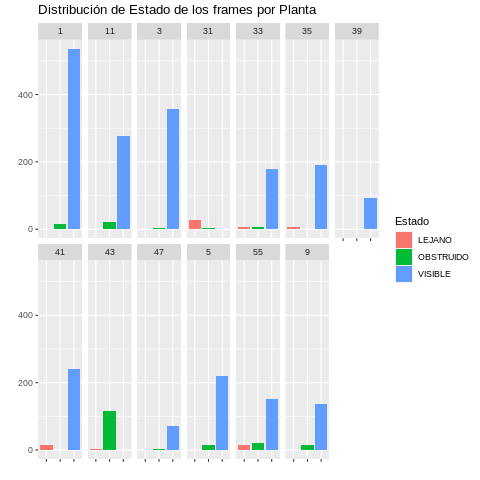

In [ ]:
%%R
plot(ggplot(data = etiquetas) +
  geom_bar(mapping = aes(x = estado, fill=estado)) + labs(x="",y="", fill="Estado") +
  scale_x_discrete(labels = c()) +
  facet_wrap(~ idPlanta, nrow = 2) + ggtitle("Distribución de Estado de los frames por Planta") 
)


Una vez aclarado esto, se muestra el total de aciertos vs errores para cada parte estructural.

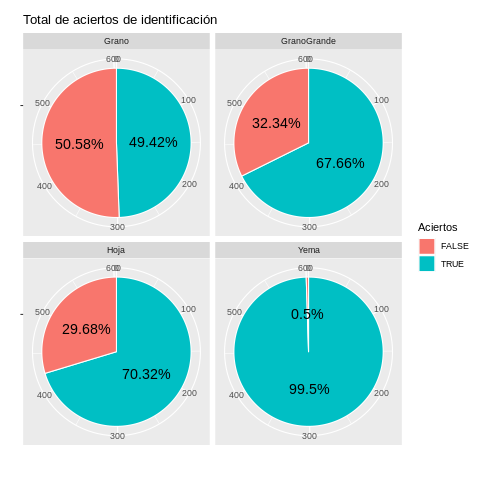

In [ ]:
%%R
resultadosTorta <- resultados %>%
                      group_by(clase, acierto) %>%
                      summarize(conteo=n()) %>%
                      arrange(desc(acierto))

resultadosTorta %<>%   group_by(clase) %>%
                        mutate(prop = paste0(round(conteo / sum(conteo) *100,2),"%")) %>%
                        mutate(ypos = cumsum(conteo)- 0.5*conteo )

ggplot(resultadosTorta, aes(x="",y=conteo, fill=acierto)) +
  geom_bar(width = 1, stat="identity", col="white") +
  coord_polar(theta="y") +
   facet_wrap(~clase, nrow=2) +
   geom_text(aes(y = ypos, label = prop), color = "black", size=5) +
   labs(x="",y="", fill="Aciertos") +
   ggtitle("Total de aciertos de identificación")


En la siguiente figura se muestra como se distribuyeron las identificaciones en los distintos objetos de la grilla simulada para cada parte estructural.

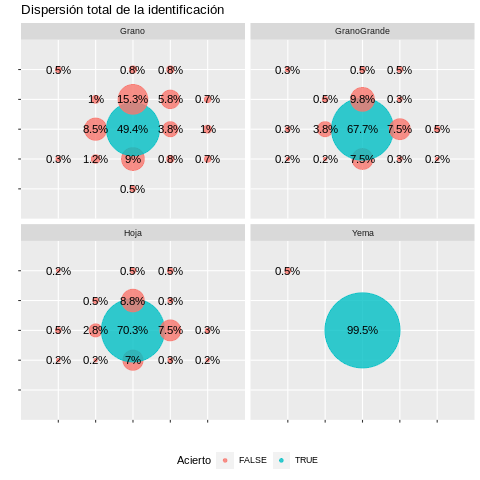

In [ ]:
%%R
porcentajesClase <- resultados %>%
                      group_by(clase, columnaPrediccion,filaPrediccion) %>%
                      summarize(conteo=n()) 
porcentajesClase %<>% group_by(clase) %>%
                        mutate(prop = paste0(round(conteo / sum(conteo) *100,1),"%")) %>%
                        mutate(ypos = cumsum(conteo)- 0.5*conteo )
ggplot(data = resultados,mapping = aes(x = columnaPrediccion, y = filaPrediccion)) + 
  geom_count(aes(size = stat(prop), colour = acierto, group = 1),alpha = 0.8) +
  scale_size_area(max_size = 35) + ggtitle("Dispersión total de la identificación") +
  scale_y_reverse(breaks = 0:4,limits=c(4,0),expand = expansion(add = 1),labels=NULL) +
  scale_x_continuous(breaks = 0:4,limits=c(0,4),expand = expansion(add = 1),labels=NULL)+
  facet_wrap(~clase, nrow=2) + labs(x="",y="", col="Acierto") +  guides(color = 'legend', size="none") + 
   geom_text(data=porcentajesClase,
             aes(x = columnaPrediccion, y = filaPrediccion, label = prop), color = "black", size=4) +
  theme(legend.position = "bottom", panel.grid.minor = element_blank())

A continuación, se muestra el rendimiento de cada marker por separado para cada parte estructural.

In [ ]:
%%R
install.packages("ggforce")
library(ggforce)


In [ ]:
%%R
install.packages("ggrepel")
library(ggrepel)

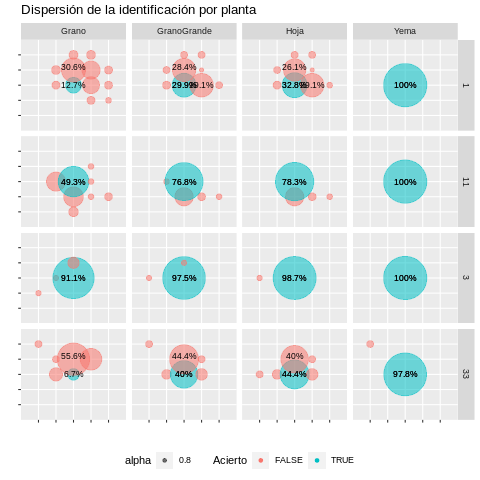

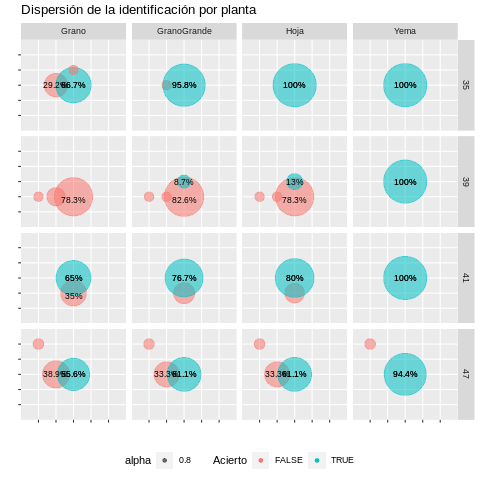

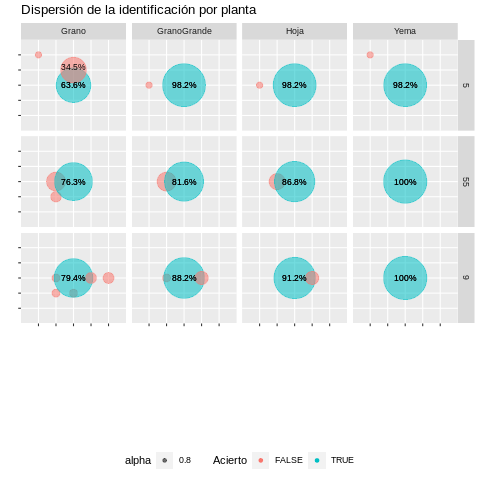

In [ ]:
%%R
porcentajesPlanta <- resultados %>%
                      group_by(clase ,idPlanta , columnaPrediccion,filaPrediccion) %>%
                      summarize(conteo=n()) 
porcentajesPlanta %<>% group_by(clase ,idPlanta ) %>%
                        mutate(propNum = conteo / sum(conteo) *100) %>%
                        mutate(prop = paste0(round(propNum,1),"%"))

p<-  ggplot(data = resultados,mapping = aes(x = columnaPrediccion, y = filaPrediccion)) +
  geom_count(aes(size = stat(prop), colour = acierto, group = 1 )) + guides(color = 'legend') + 
  scale_size_area(max_size = 20) + ggtitle("Dispersión de la identificación por planta") +
  scale_y_reverse(breaks = NULL,limits=c(2,0)) + scale_x_continuous(breaks = NULL,limits=c(0,4))+
  geom_text(data=filter(porcentajesPlanta), 
             aes(x = columnaPrediccion, y = filaPrediccion, label = prop), color = "black", size=3,vjust = "inward") +
  facet_grid_paginate( idPlanta ~ clase,ncol=4,nrow=4,page=1)+
  theme(legend.position = "none") + labs(x="",y="")

for(i in 1:n_pages(p)){
  plot(
    ggplot(data = resultados,mapping = aes(x = columnaPrediccion, y = filaPrediccion)) +
    geom_count(aes(size = stat(prop), colour = acierto, group = 1, alpha=0.8 )) + 
    scale_size_area(max_size = 20) + ggtitle("Dispersión de la identificación por planta") +
    scale_y_reverse(breaks = 0:4,limits=c(4,0),expand = expansion(add = 1),labels=NULL) +
    scale_x_continuous(breaks = 0:4,limits=c(0,4),expand = expansion(add = 1),labels=NULL)+
    geom_text(data=filter(porcentajesPlanta,columnaPrediccion==2,filaPrediccion==2), 
             aes(x = columnaPrediccion, y = filaPrediccion, label = prop), color = "black", size=3)+
    geom_text(data=filter(porcentajesPlanta,propNum>25), 
              aes(x = columnaPrediccion, y = filaPrediccion, label = prop), color = "black", size=3,vjust = "outward") +
    facet_grid_paginate( idPlanta ~ clase,ncol=4,nrow=4,page=i)+
    theme(legend.position = "bottom", panel.grid.minor = element_blank()) + labs(x="",y="",col="Acierto")  +  guides(color = 'legend', size="none") 
  )
}    

# Análisis de los Resultados

Siempre y cuando el objeto correcto sea identificado la mayoría de las veces se pueden establecer estrategias para que la identificación funcione. Como por ejemplo solicitar al usuario que ingrese un pequeño video en lugar de un solo frame. De esta manera cada frame tendrá un objeto identificado y se podría utilizar un esquema de votación para identificar el correcto.

Sin embargo, en la siguiente gráfica se ve que el error de reproyección en las plantas que rompieron el esquema de identificación tienen un desfasaje de entre 2 y 3 cm con el resto de las plantas. Esto podría indicar que con un mejor protocolo de captura de videos se podría mejorar la precisón y reducir levemente estos errores para lograr que el esquema funcione para estos casos también.

In [ ]:
%%R
errorDf <-resumenEtiquetas %>% separate(idEtiqueta, into = c("idPlanta", "frame"),sep="-" ) %>%
              mutate(errorCm = sqrt(
                                  (xCentroRep - xCentroTrue) * (xCentroRep - xCentroTrue) +
                                  (yCentroRep - yCentroTrue) * (yCentroRep - yCentroTrue)
                                    ) / pixelsCmRatio,
                     buena = !(idPlanta %in% c("1","33","39"))
              )

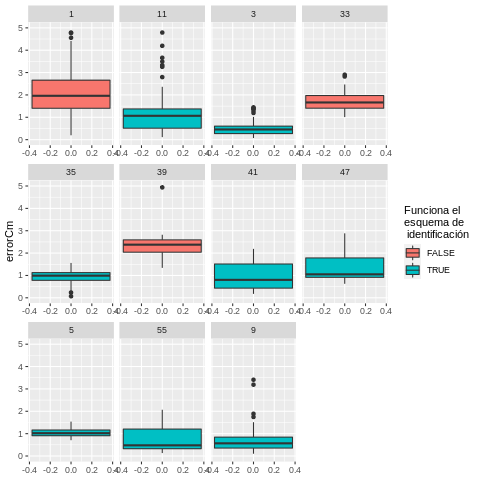

In [ ]:
%%R
ggplot(errorDf , aes(y=errorCm))+
  geom_boxplot(aes(fill=buena)) + facet_wrap(~idPlanta, scales= "free_x") +
  scale_y_continuous(lim= c(0,5)) + 
  labs(fill="Funciona el \nesquema de\n identificación")